In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer,Reshape, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In [2]:
# Load the data
x_train = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv", header=None)
y_train = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv", header=None)
x_test = pd.read_csv(r"/kaggle/input/ahcd1/csvTestImages 3360x1024.csv", header=None)
y_test = pd.read_csv(r"/kaggle/input/ahcd1/csvTestLabel 3360x1.csv", header=None)

# Reshape the data
x_train = x_train.values.reshape(-1, 32, 32, 1) / 255.0
x_test = x_test.values.reshape(-1, 32, 32, 1) / 255.0

# Convert labels to categorical
total_classes = len(np.unique(y_train)) + 1
y_train = to_categorical(y_train, total_classes)
y_test = to_categorical(y_test, total_classes)



In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Bidirectional, GRU, Reshape


# Custom Layer for Neutrosophic Transformation
class NeutrosophicTransformation(layers.Layer):
    def __init__(self, **kwargs):
        super(NeutrosophicTransformation, self).__init__(**kwargs)
    
    def call(self, inputs):
        T = inputs
        I = 0.1 * tf.random.uniform(shape=tf.shape(inputs))  # Create indeterminacy component
        F = 1 - T - I  # Create falsity component
        return T, I, F

    def compute_output_shape(self, input_shape):
        return [input_shape, input_shape, input_shape]

# Custom Neutrosophic Layer
class NeutrosophicLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(NeutrosophicLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        T, I, F = inputs
        # Concatenate T, I, and F along the channel axis
        return tf.concat([T, I, F], axis=-1)
    
    def compute_output_shape(self, input_shape):
        # Compute the output shape after concatenation
        # input_shape is a list of 3 tensors with shapes [(batch_size, height, width, channels), ...]
        shape = list(input_shape[0])  # Take the shape of T (or I, or F)
        shape[-1] *= 3  # Multiply the number of channels by 3
        return tuple(shape)

# Build the model with neutrosophic layers
def build_model_neutrosophic(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Convert inputs to neutrosophic numbers using the custom layer
    T, I, F = NeutrosophicTransformation()(inputs)
    
    # Apply neutrosophic processing using another custom layer
    x = NeutrosophicLayer()([T, I, F])
    
    # Continue with the rest of the model
    x = Conv2D(64, (3, 3), padding='valid', activation='relu',strides=1,
            kernel_initializer='HeNormal')(x)
    x = Conv2D(64, (3, 3), padding='valid', activation='relu',strides=1)(x)
    x = MaxPooling2D((2, 2),strides=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), padding='valid', activation='relu',strides=1)(x)
    x = MaxPooling2D((2, 2),strides=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), padding='valid', activation='relu',strides=1)(x)
    x = MaxPooling2D((2, 2),strides=1)(x)
    x = BatchNormalization()(x)
    
     # Reshape to prepare for GRU layers
    x = layers.Lambda(lambda t: tf.reshape(t, (-1, t.shape[1] * t.shape[2], t.shape[3])))(x)
    
    x = BatchNormalization()(x)
    # Stacking 4 Bi-GRU layers
    x = Bidirectional(GRU(256, return_sequences=True))(x)
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = Bidirectional(GRU(32, return_sequences=False))(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(29, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Build and compile the model
model = build_model_neutrosophic((32, 32, 1))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Assuming x_train, y_train, x_test, y_test are already defined and preprocessed
# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test))

# Evaluate the model
model.evaluate(x_test, y_test, verbose=2)

# Make predictions
y_held_pred = model.predict(x_test)
y_pred = np.argmax(y_held_pred, axis=1)
y_test_1 = np.argmax(y_test, axis=1)

# Display the evaluation metrics
from sklearn.metrics import classification_report
print(classification_report(y_test_1, y_pred))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neutrosophic_trans… │ [(None, 32, 32,   │          0 │ input_layer[0][0] │
│ (NeutrosophicTrans… │ 1), (None, 32,    │            │                   │
│                     │ 32, 1), (None,    │            │                   │
│                     │ 32, 32, 1)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neutrosophic_layer  │ (None, 32, 32, 3) │          0 │ neutrosophic_tra… │
│ (NeutrosophicLayer) │                   │            │ neutrosophic_tra… │
│                     │                   │            │ neutrosophic_tra… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      1,792 │ neutrosophic_lay… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 27, 27,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 27, 27,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 21, 21,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 441, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 441, 128)  │        512 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 441, 512)  │    592,896 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                 

 Total params: 2,090,973 (7.98 MB)

 Trainable params: 2,090,077 (7.97 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 64s 254ms/step - accuracy: 0.1748 - loss: 2.6635 - val_accuracy: 0.1176 - val_loss: 4.3138
Epoch 2/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.6331 - loss: 1.0182 - val_accuracy: 0.3449 - val_loss: 2.8839
Epoch 3/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.8525 - loss: 0.4308 - val_accuracy: 0.8107 - val_loss: 0.5918
Epoch 4/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.9209 - loss: 0.2351 - val_accuracy: 0.8774 - val_loss: 0.4006
Epoch 5/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.9426 - loss: 0.1757 - val_accuracy: 0.1193 - val_loss: 6.8754
Epoch 6/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.9554 - loss: 0.1399 - val_accuracy: 0.1664 - val_loss: 6.2361
Epoch 7/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.9667 - loss: 0.1058 - val_accuracy: 0.9119 - val_loss: 0.2965
Epoch 8/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.9703 -

In [4]:
y_held_pred=model.predict(x_test)

105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


In [5]:
y_pred=np.argmax(y_held_pred, axis=1)
y_test_1=np.argmax(y_test, axis=1)

print(y_test_1.shape)
print(y_pred.shape)

(3360,)
(3360,)


In [6]:
model.evaluate(x_test,y_test)

105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.9643 - loss: 0.3211


[0.24751242995262146, 0.9726190567016602]

In [7]:
his=model.evaluate(x_test, y_test, verbose=2);
print(his)

105/105 - 7s - 71ms/step - accuracy: 0.9738 - loss: 0.2391
[0.23907692730426788, 0.973809540271759]


In [8]:
y_held_pred_train=model.predict(x_train)

420/420 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step


In [9]:
y_pred_train=np.argmax(y_held_pred_train, axis=1)
y_train_1=np.argmax(y_train, axis=1)

print(y_train_1.shape)
print(y_pred_train.shape)
model.evaluate(x_train, y_train, verbose=2);

(13440,)
(13440,)
420/420 - 30s - 71ms/step - accuracy: 0.9987 - loss: 0.0039


In [10]:
# Make predictions
y_held_pred = model.predict(x_test)
y_pred = np.argmax(y_held_pred, axis=1)
y_test_1 = np.argmax(y_test, axis=1)



105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Actual G*', ylabel='Predicted G*'>

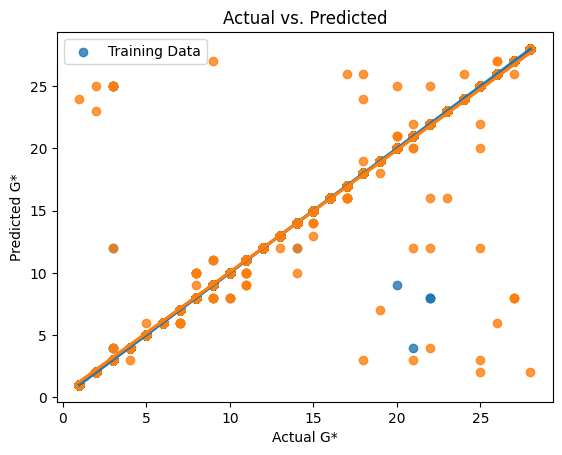

In [11]:
import seaborn as sns

sns.regplot(x=y_train_1,y=y_pred_train, label="Training Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

sns.regplot(x=y_test_1,y=y_pred, label="Testing Data")

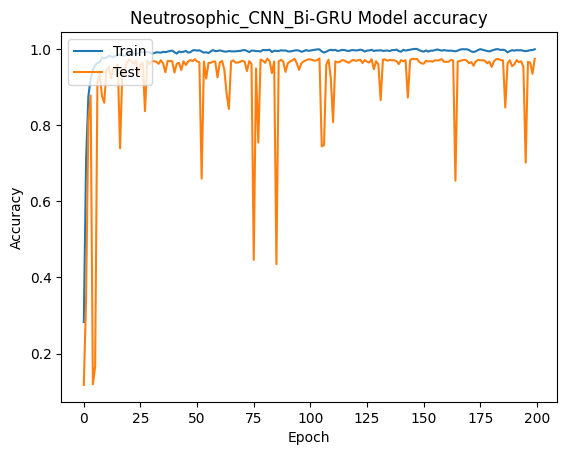

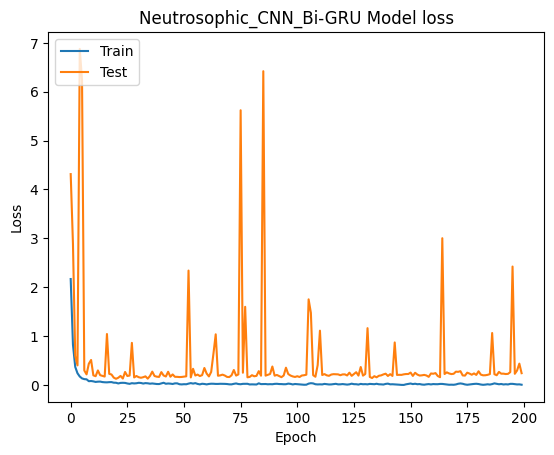

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Neutrosophic_CNN_Bi-GRU Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neutrosophic_CNN_Bi-GRU Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [13]:
y_predicted = model.predict(x_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_grand_truth, y_predicted)

105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


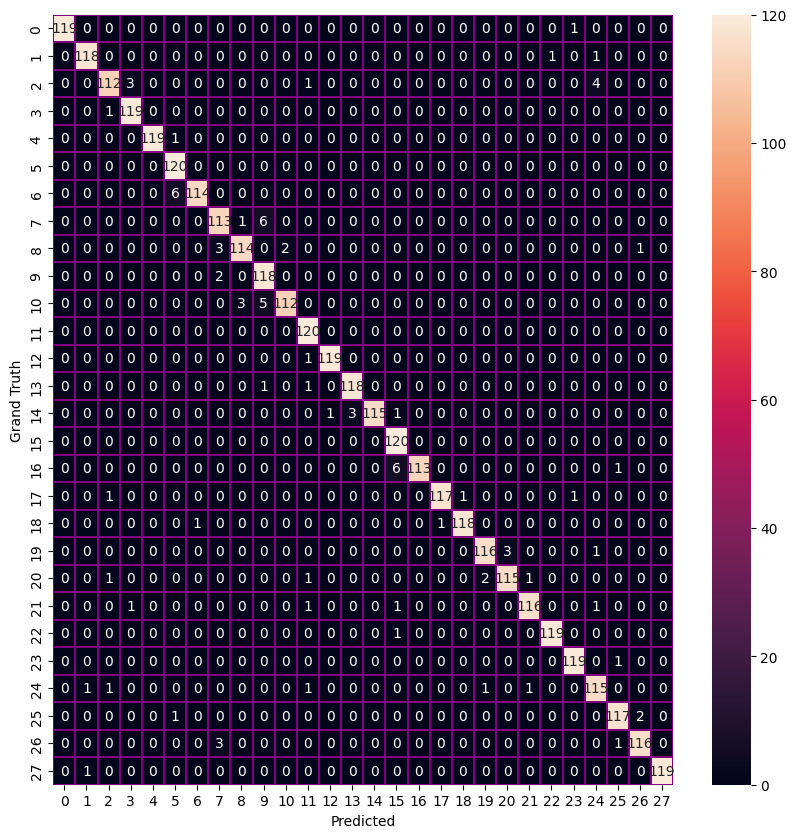

In [14]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.1, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [15]:
scores = np.zeros((28,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(28):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 28))])

In [16]:
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix

# Functions: Performance Evaluation 

def Performance(Model , y_predd): 
    
    # model accuracy
    accuracy = accuracy_score(y_test_1, y_predd)
    print( Model +' Accuracy:'+'\033[1m {:.2f}%'.format(accuracy*100))
    
    # model Classification Report
    print('\nClassification Report: '+'\033[0m')
    print('*' * 22)
    print(classification_report(y_test_1, y_predd))

In [17]:
Performance('neutrosophic_CNN_Bi-GRU' , y_pred)

neutrosophic_CNN_Bi-GRU Accuracy: 97.38%

Classification Report: 
**********************
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       120
           2       0.98      0.98      0.98       120
           3       0.97      0.94      0.95       120
           4       0.98      0.99      0.98       120
           5       1.00      0.99      1.00       120
           6       0.94      1.00      0.97       120
           7       0.99      0.95      0.97       120
           8       0.93      0.95      0.94       120
           9       0.97      0.95      0.96       120
          10       0.91      0.98      0.95       120
          11       0.98      0.93      0.96       120
          12       0.95      1.00      0.98       120
          13       0.99      0.99      0.99       120
          14       0.98      0.98      0.98       120
          15       1.00      0.97      0.98       120
          16       0.94      1.00      0.97   